In [1]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("RetailChain")
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000")
    .config("spark.hadoop.dfs.client.use.datanode.hostname", "true")
    .getOrCreate()
)

sales_path    = "hdfs://namenode:9000/retailchain/data/Sales.csv"
features_path = "hdfs://namenode:9000/retailchain/data/Features.csv"
stores_path   = "hdfs://namenode:9000/retailchain/data/Stores.csv"

sales    = spark.read.csv(sales_path, header=True, inferSchema=True)
features = spark.read.csv(features_path, header=True, inferSchema=True)
stores   = spark.read.csv(stores_path, header=True, inferSchema=True)

print("Sales rows:", sales.count())
print("Features rows:", features.count())
print("Stores rows:", stores.count())

sales.printSchema()
features.printSchema()
stores.printSchema()


Sales rows: 421570
Features rows: 8190
Stores rows: 45
root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

root
 |-- Store: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: string (nullable = true)
 |-- MarkDown2: string (nullable = true)
 |-- MarkDown3: string (nullable = true)
 |-- MarkDown4: string (nullable = true)
 |-- MarkDown5: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

root
 |-- Store: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)



In [4]:
sales.show(5, truncate=False)
features.show(5, truncate=False)
stores.show(5, truncate=False)

+-----+----+----------+------------+---------+
|Store|Dept|Date      |Weekly_Sales|IsHoliday|
+-----+----+----------+------------+---------+
|1    |1   |05/02/2010|24924.5     |false    |
|1    |1   |12/02/2010|46039.49    |true     |
|1    |1   |19/02/2010|41595.55    |false    |
|1    |1   |26/02/2010|19403.54    |false    |
|1    |1   |05/03/2010|21827.9     |false    |
+-----+----+----------+------------+---------+
only showing top 5 rows

+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|Store|Date      |Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|CPI        |Unemployment|IsHoliday|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|1    |05/02/2010|42.31      |2.572     |NA       |NA       |NA       |NA       |NA       |211.0963582|8.106       |false    |
|1    |12/02/2010|38.51      |2.548     |NA 

In [5]:
from pyspark.sql.functions import col, to_date, when
from pyspark.sql.types import DoubleType

# Convert Date from string -> date
sales = sales.withColumn("Date", to_date(col("Date"), "dd/MM/yyyy"))
features = features.withColumn("Date", to_date(col("Date"), "dd/MM/yyyy"))

# Fill MarkDown NA/null with 0
md_cols = ["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]
for c in md_cols:
    features = features.withColumn(
        c,
        when((col(c).isNull()) | (col(c) == "NA"), 0).otherwise(col(c)).cast(DoubleType())
    )

# Ensure numeric columns are numeric 
num_cols = ["Temperature","Fuel_Price","CPI","Unemployment"]
for c in num_cols:
    features = features.withColumn(c, col(c).cast(DoubleType()))

# Check date conversion worked
sales.select("Date").show(5)
features.select("Date", "MarkDown1", "Fuel_Price").show(5, truncate=False)


+----------+
|      Date|
+----------+
|2010-02-05|
|2010-02-12|
|2010-02-19|
|2010-02-26|
|2010-03-05|
+----------+
only showing top 5 rows

+----------+---------+----------+
|Date      |MarkDown1|Fuel_Price|
+----------+---------+----------+
|2010-02-05|0.0      |2.572     |
|2010-02-12|0.0      |2.548     |
|2010-02-19|0.0      |2.514     |
|2010-02-26|0.0      |2.561     |
|2010-03-05|0.0      |2.625     |
+----------+---------+----------+
only showing top 5 rows



In [6]:
# Join: sales + features (Store, Date) then add store info
gold = sales.join(features, on=["Store","Date","IsHoliday"], how="left") \
            .join(stores, on="Store", how="left")

gold.cache()
print("Gold rows:", gold.count())
gold.select("Store","Type","Size","Dept","Date","Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment").show(5, truncate=False)
gold.printSchema()


Gold rows: 421570
+-----+----+------+----+----------+------------+-----------+----------+-----------+------------+
|Store|Type|Size  |Dept|Date      |Weekly_Sales|Temperature|Fuel_Price|CPI        |Unemployment|
+-----+----+------+----+----------+------------+-----------+----------+-----------+------------+
|1    |A   |151315|1   |2010-02-05|24924.5     |42.31      |2.572     |211.0963582|8.106       |
|1    |A   |151315|1   |2010-02-12|46039.49    |38.51      |2.548     |211.2421698|8.106       |
|1    |A   |151315|1   |2010-02-19|41595.55    |39.93      |2.514     |211.2891429|8.106       |
|1    |A   |151315|1   |2010-02-26|19403.54    |46.63      |2.561     |211.3196429|8.106       |
|1    |A   |151315|1   |2010-03-05|21827.9     |46.5       |2.625     |211.3501429|8.106       |
+-----+----+------+----+----------+------------+-----------+----------+-----------+------------+
only showing top 5 rows

root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Is

In [7]:
print("Null Date in gold:", gold.filter(col("Date").isNull()).count())
print("Null Weekly_Sales:", gold.filter(col("Weekly_Sales").isNull()).count())


Null Date in gold: 0
Null Weekly_Sales: 0


In [8]:
from pyspark.sql.functions import sum as Fsum, col

top_10_stores = gold.groupBy("Store") \
    .agg(Fsum("Weekly_Sales").alias("TotalSales")) \
    .orderBy(col("TotalSales").desc()) \
    .limit(10)

top_10_stores.show()


+-----+--------------------+
|Store|          TotalSales|
+-----+--------------------+
|   20|3.0139779245999974E8|
|    4|2.9954395337999994E8|
|   14| 2.889999113399997E8|
|   13| 2.865177037999985E8|
|    2| 2.753824409800004E8|
|   10| 2.716177138899999E8|
|   27| 2.538559168800001E8|
|    6|2.2375613063999987E8|
|    1| 2.224028088499993E8|
|   39|2.0744554247000024E8|
+-----+--------------------+



In [9]:
top10_pd = top_10_stores.toPandas()

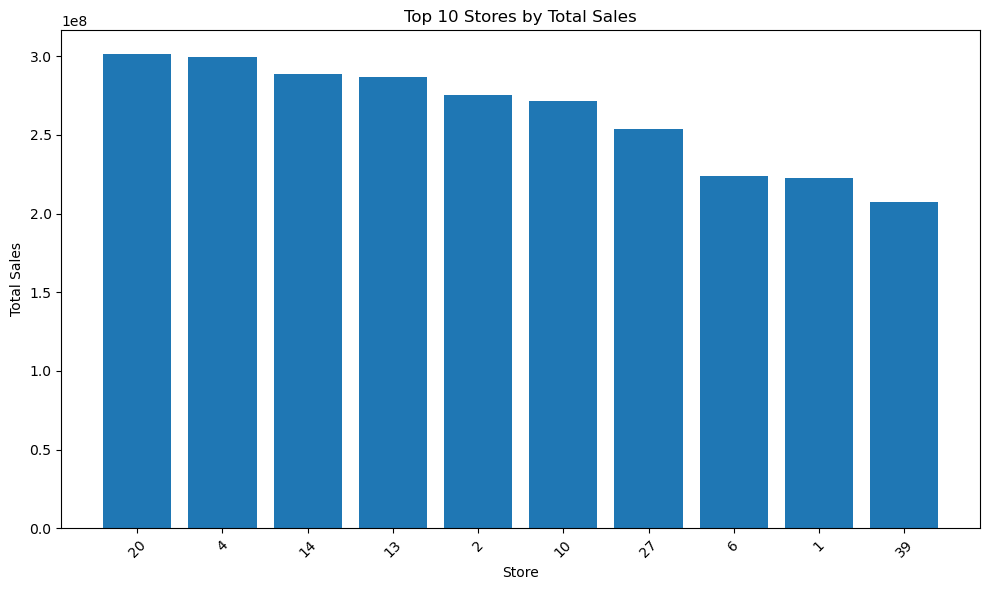

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.bar(top10_pd["Store"].astype(str),
        top10_pd["TotalSales"])

plt.xlabel("Store")
plt.ylabel("Total Sales")
plt.title("Top 10 Stores by Total Sales")

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [11]:
from pyspark.sql.functions import avg as Favg, count as Fcount

holiday_impact = gold.groupBy("IsHoliday") \
    .agg(
        Favg("Weekly_Sales").alias("AvgWeeklySales"),
        Fsum("Weekly_Sales").alias("TotalSales"),
        Fcount("*").alias("RowCount")
    )

holiday_impact.show()


+---------+------------------+--------------------+--------+
|IsHoliday|    AvgWeeklySales|          TotalSales|RowCount|
+---------+------------------+--------------------+--------+
|     true| 17035.82318735039|5.0529955155999994E8|   29661|
|    false|15901.445069008774| 6.231919435550159E9|  391909|
+---------+------------------+--------------------+--------+



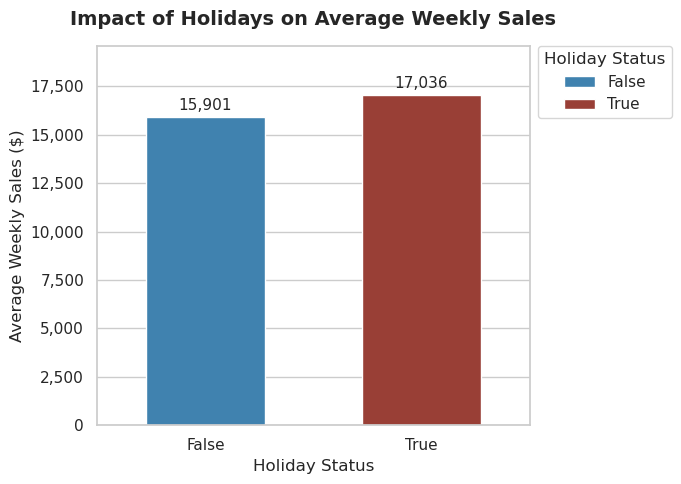

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

sns.set_theme(style="whitegrid")

holiday_pd = holiday_impact.toPandas()

plt.figure(figsize=(7,5))

# Assign hue=x to avoid FutureWarning
ax = sns.barplot(
    x="IsHoliday",
    y="AvgWeeklySales",
    hue="IsHoliday",
    data=holiday_pd,
    palette=["#2E86C1", "#A93226"],
    dodge=False,
    width=0.55  # reduce bar width
)

# Format Y axis
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Increase top space to prevent overlap
ax.set_ylim(0, holiday_pd["AvgWeeklySales"].max() * 1.15)

# Add value labels 
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Ignore zero-height bars
        ax.annotate(f'{height:,.0f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center',
                    va='bottom',
                    fontsize=11,
                    xytext=(0, 3),
                    textcoords='offset points')

plt.title("Impact of Holidays on Average Weekly Sales",
          fontsize=14,
          weight='bold',
          pad=15)

plt.xlabel("Holiday Status", fontsize=12)
plt.ylabel("Average Weekly Sales ($)", fontsize=12)

# legend
plt.legend(
    title="Holiday Status",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.savefig("holiday_sales_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
from pyspark.sql.functions import year, month

monthly = gold.withColumn("Year", year("Date")) \
              .withColumn("Month", month("Date")) \
              .groupBy("Year", "Month") \
              .agg(Fsum("Weekly_Sales").alias("MonthlySales")) \
              .orderBy("Year", "Month")

monthly.show(12)


+----+-----+--------------------+
|Year|Month|        MonthlySales|
+----+-----+--------------------+
|2010|    2|1.9033298303999975E8|
|2010|    3|1.8191980249999988E8|
|2010|    4|2.3141236804999948E8|
|2010|    5|1.8671093434000015E8|
|2010|    6|1.9224617236000022E8|
|2010|    7|2.3258012597999993E8|
|2010|    8|1.8764011088999993E8|
|2010|    9|1.7726789637000018E8|
|2010|   10|2.1716182402000016E8|
|2010|   11|2.0285337014000016E8|
|2010|   12|2.8876053272000027E8|
|2011|    1| 1.637039668299999E8|
+----+-----+--------------------+
only showing top 12 rows



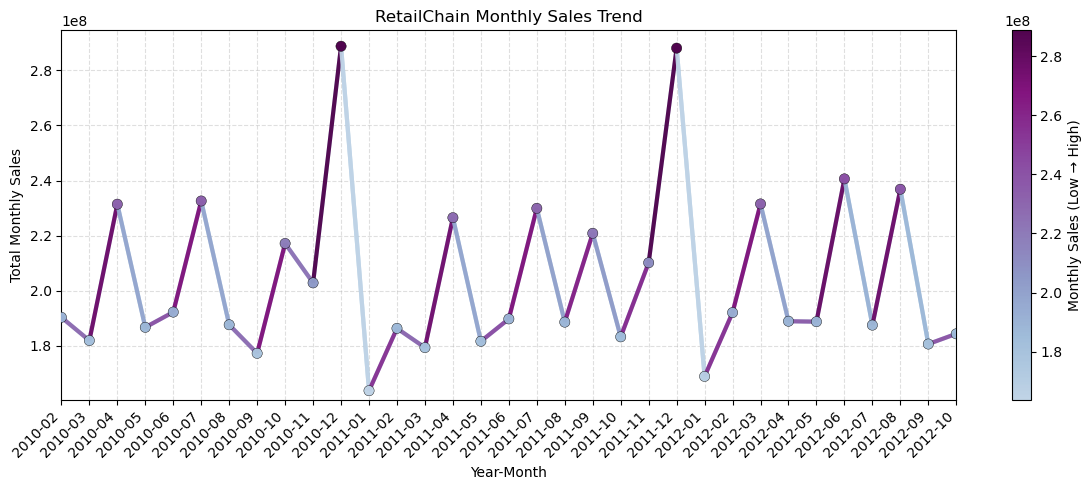

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

# helper: truncate colormap so it never becomes white
def truncate_colormap(cmap, minval=0.25, maxval=1.0, n=256):
    return mcolors.LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )

pdf = monthly.toPandas()
pdf["YearMonth"] = pdf["Year"].astype(str) + "-" + pdf["Month"].astype(str).str.zfill(2)

x = np.arange(len(pdf))
y = pdf["MonthlySales"].values

# ---------- LINE segments ----------
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

diff = np.diff(y)  # up/down change

# Use colormap but remove near-white colors
base_cmap = plt.cm.BuPu
cmap_no_white = truncate_colormap(base_cmap, minval=0.25, maxval=1.0)

# Normalize line colors by diff (robust)
norm_line = mcolors.Normalize(vmin=np.percentile(diff, 5), vmax=np.percentile(diff, 95))

lc = LineCollection(segments, cmap=cmap_no_white, norm=norm_line)
lc.set_array(diff)
lc.set_linewidth(3)
lc.set_alpha(0.95)

# ---------- POINT colors by absolute sales ----------
norm_points = mcolors.Normalize(vmin=y.min(), vmax=y.max())

fig, ax = plt.subplots(figsize=(12,5))

# ✅ base line under everything (ensures start is visually continuous)
ax.plot(x, y, linewidth=3, alpha=0.25)

# colored segments on top
ax.add_collection(lc)

# points
sc = ax.scatter(
    x, y,
    c=y,
    cmap=cmap_no_white,   # also avoid white for low values
    norm=norm_points,
    s=55,
    edgecolors="black",
    linewidths=0.3,
    alpha=0.98,
    zorder=3
)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min()*0.98, y.max()*1.02)

ax.set_xticks(x)
ax.set_xticklabels(pdf["YearMonth"], rotation=45, ha="right")

ax.set_title("RetailChain Monthly Sales Trend")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Total Monthly Sales")

# grid
ax.grid(True, linestyle="--", alpha=0.4)

# colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Monthly Sales (Low → High)")

plt.tight_layout()
plt.show()


In [15]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Convert Type to numeric
indexer = StringIndexer(inputCol="Type", outputCol="TypeIndex")

# Feature columns
feature_cols = [
    "Store",
    "Dept",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "IsHoliday",
    "TypeIndex"
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="Weekly_Sales",
    numTrees=50
)

pipeline = Pipeline(stages=[indexer, assembler, rf])

# Train/test split
train, test = gold.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train)
predictions = model.transform(test)

predictions.select("Weekly_Sales", "prediction").show(5)


+------------+------------------+
|Weekly_Sales|        prediction|
+------------+------------------+
|    13740.12|23549.535029243583|
|    21084.08|23646.219321465385|
|    16930.99|23646.219321465385|
|    19466.91|23240.284625421806|
|     8907.63|14817.044270642118|
+------------+------------------+
only showing top 5 rows



In [16]:
evaluator = RegressionEvaluator(
    labelCol="Weekly_Sales",
    predictionCol="prediction",
    metricName="rmse"
)

rmse = evaluator.evaluate(predictions)
print("RMSE:", rmse)

evaluator_r2 = RegressionEvaluator(
    labelCol="Weekly_Sales",
    predictionCol="prediction",
    metricName="r2"
)

r2 = evaluator_r2.evaluate(predictions)
print("R2:", r2)


RMSE: 18152.67711334845
R2: 0.3614279829565067


In [17]:
import pandas as pd

# Find the last stage (regressor model)
rf_model = model.stages[-1]

# Spark returns a SparseVector -> convert to python list
importances = rf_model.featureImportances.toArray().tolist()

feature_names = assembler.getInputCols()

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

importance_df


,Feature,Importance
1,Dept,0.668216
7,TypeIndex,0.198977
0,Store,0.092492
4,CPI,0.024238
5,Unemployment,0.012808
2,Temperature,0.001833
3,Fuel_Price,0.001427
6,IsHoliday,0.000008


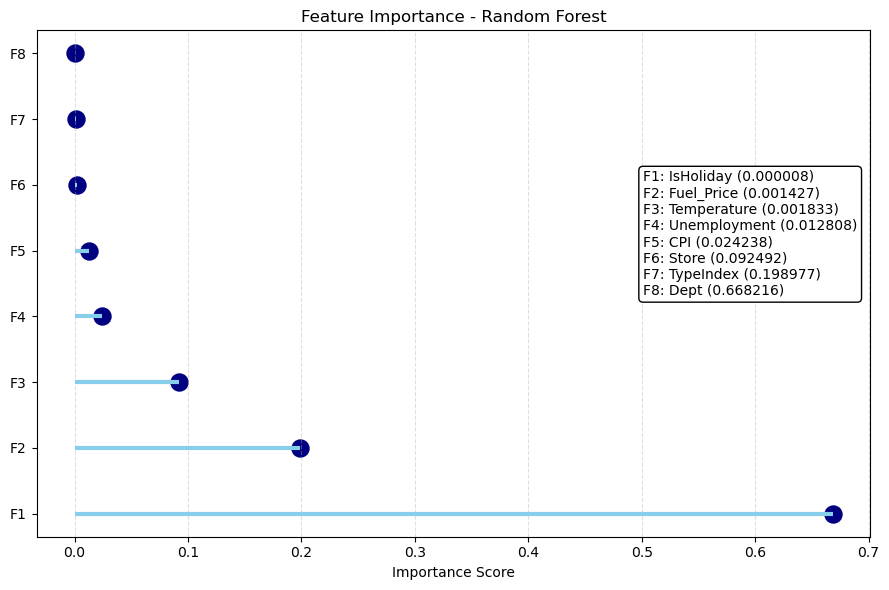

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Reset index for numbering
importance_df = importance_df.reset_index(drop=True)

# Reverse order for better visual alignment (largest on top)
importance_df = importance_df.iloc[::-1]

plt.figure(figsize=(9,6))

# Lollipop stems
plt.hlines(
    y=range(len(importance_df)),
    xmin=0,
    xmax=importance_df["Importance"],
    color="skyblue",
    linewidth=3
)

# Points
plt.scatter(
    importance_df["Importance"],
    range(len(importance_df)),
    s=150,
    color="navy"
)

plt.yticks(range(len(importance_df)),
           [f"F{i+1}" for i in range(len(importance_df))])

plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.grid(axis="x", linestyle="--", alpha=0.4)

# --------- Legend Box WITH VALUES ----------
legend_text = "\n".join(
    [
        f"F{i+1}: {row.Feature} ({row.Importance:.6f})"
        for i, row in importance_df.iloc[::-1].reset_index().iterrows()
    ]
)

plt.gcf().text(
    0.72, 0.5,
    legend_text,
    fontsize=10,
    bbox=dict(facecolor="white",
              edgecolor="black",
              boxstyle="round")
)

plt.tight_layout()
plt.show()
